重要性采样要解决的是同策略的算法在每次采样后都需要更新策略的问题，如果我们希望能有更高的效率，一定希望能够进行一个批次的采样后再更新策略，而不是采样一步就更新策略再用新策略再采样，批量采样后一次更新可以节省大量更新策略花费的时间。
问题在于采样一个批次后更新策略时随着策略的更新，新策略已经和采样时使用的旧策略偏移了，该如何修正这种偏移呢，就可以使用重要性权重，将原始的优势乘以重要性权重得到新策略下的优势。乘以重要性权重这一操作从直观上看类似将新的概率分布和旧概率分布相除得到差异值，乘以这种差异就得到了满足新分布下的优势值，但这一表述并不严谨，具体的证明可以参考书中的内容。![重要性采样](https://datawhalechina.github.io/easy-rl/#/chapter5/chapter5?id=_51-%e9%87%8d%e8%a6%81%e6%80%a7%e9%87%87%e6%a0%b7)

PPO相对重要性采样更进一步解决了分布之间的差异问题，使用这种估计的方法用旧策略采样得到的结果估计新策略存在的问题在于新旧策略之间的差异不能太大，差异太大的问题是使用旧策略采样得到的样本对于新策略来说，和直接使用新策略采样相比，方差会大得多，方差大对于新策略的估计存在的影响是方差大可能导致对新策略的真实期望的估计存在很大的偏移。因为我们对期望的估计都是通过采样得到样本，再用得到的样本来估计的，我们不可能直接得到原始的真实分布，方差大就意味着采样数量有限的情况下偏移真实分布的可能性更大（如可能都比真实期望大，那计算得出的期望就会偏大），当然这种偏移可以随着采样数量的增多不断缓解，但实际上采样的“多”或者“少”本身也是我们很难评估的问题，限制新旧策略的分布之间不要有太大的差异就可以缓解这种影响，使得采样尽可能稳定的接近真实分布。

有了以上理解，就可以尝试动手写代码了，当一个算法环节比较多，且各个部分我们的理解的都还不够深入的时候，先写一个不那么标准的伪代码把整体流程大概表达出来，再一步步的实现会让我们的思路清晰很多（当特别熟练招之即来的时候这一步就不需要了） 

1. 需要采样，采样得到的是经典的四元组(S,A,R,S')，表示当前状态，采样得到的动作，对该状态采取A动作后得到的奖励R，以及转变成的下一个状态S'。我们需要一种方式保存旧策略采样得到的经验，这里可以和之前DQN的一样使用一个经验池，只是在从经验池中取出经验的时候不像DQN只取出一个批次的经验，而是取出全部经验（因为我们对采样得到的经验只会使用一次，不像DQN中会重复使用），因此重写取出经验的方法，其余的可以复用。

In [8]:
from collections import deque
import random
class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque(maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放,append在队列库的实现中是右侧放入,队列满的时候左侧的元素会被自动弹出，形成FIFO
        '''
        self.buffer.append(transitions)
    def sample(self, batch_size: int, sequential: bool = False):
        if batch_size > len(self.buffer): # 如果批量大小大于经验回放的容量，则取经验回放的容量
            batch_size = len(self.buffer)
        if sequential: # 随机开始位置的顺序采样
            rand = random.randint(0, len(self.buffer) - batch_size)
            batch = [self.buffer[i] for i in range(rand, rand + batch_size)]
            return zip(*batch)
        else: # 随机采样
            batch = random.sample(self.buffer, batch_size)
            return zip(*batch)
    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)
class PGReplay(ReplayBuffer):
    def __init__(self):
        self.buffer = deque()
    def sample(self):
        ''' sample all the transitions
        '''
        batch = list(self.buffer)
        return zip(*batch) #这里得到的是list

2. 使用旧策略采样，得到的经验放入经验池中，采样到一个指定数量后停止采样。从经验池中取出经验，因为CarPole-v1是有限步停止的，不是无限进行下去的环境，因此可以使用蒙特卡罗方法倒推每一步得到的奖励（如果是无限进行的则要像之前的DQN一样使用网络估计奖励），此处可以使用折扣奖励，即越远的奖励影响越小，从递推的角度来说即每次都将上一次的奖励乘以一个折扣因子和当前奖励相加。这部分为
```python
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample()
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        # monte carlo estimate of state rewards
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
```

3. 得到奖励后，需要计算优势函数和重要性权重，优势函数的计算和之前DQN的类似，用奖励减去对应状态的价值（状态价值可通过网络估计）。重要性权重由书中讲解知可用策略在状态S下采取行动A的概率代替策略对状态S,行为A的联合概率。对(S,A)的联合概率需要我们知道S的边缘概率，但如果用替代概率则可直接由网络得出S下采取行动A的条件概率，计算起来更加容易。由于此处使用了pytorch中的Categorical，则可以利用Categorical中自带的对数概率，将原本的新策略和旧策略的条件概率的比值转换为对应的对数概率的差值，这里还使用了PPO-Clip防止这个比值过大或过小。结合上面的部分，整个更新函数如下
```python
def update(self):
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample()
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        # monte carlo estimate of state rewards
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        for _ in range(self.k_epochs):
            # compute advantage
            values = self.critic(old_states) # detach to avoid backprop through the critic
            advantage = returns - values.detach()
            # get action probabilities
            probs = self.actor(old_states)
            dist = Categorical(probs)
            # get new action probabilities
            new_probs = dist.log_prob(old_actions)
            # compute ratio (pi_theta / pi_theta__old):
            ratio = torch.exp(new_probs - old_log_probs) # old_log_probs must be detached
            # compute surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage
            # compute actor loss
            actor_loss = -torch.min(surr1, surr2).mean() + self.entropy_coef * dist.entropy().mean()
            # compute critic loss
            critic_loss = (returns - values).pow(2).mean()
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.memory.clear()
```

定义一个网络来表示做决策的模型，这里就用MLP

In [2]:
import torch.nn as nn
import torch.nn.functional as F
class ActorSoftmax(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(ActorSoftmax, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        probs = F.softmax(self.fc3(x),dim=1)
        return probs
class Critic(nn.Module):
    def __init__(self,input_dim,output_dim,hidden_dim=256):
        super(Critic,self).__init__()
        assert output_dim == 1 # critic must output a single value
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
    def forward(self,x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        value = self.fc3(x)
        return value

定义完整的智能体，除了上面的更新智能体的函数外，还要定义智能体初始化时的相关参数与初始化状态，以及定义输入状态根据网络采样得到行为的函数（用于训练和用于推理时，两个函数，推理时函数不参与梯度计算）

In [3]:
import torch
from torch.distributions import Categorical
class Agent:
    def __init__(self,cfg) -> None:
        
        self.gamma = cfg.gamma
        self.device = torch.device(cfg.device) 
        self.actor = ActorSoftmax(cfg.n_states,cfg.n_actions, hidden_dim = cfg.actor_hidden_dim).to(self.device)
        self.critic = Critic(cfg.n_states,1,hidden_dim=cfg.critic_hidden_dim).to(self.device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.memory = PGReplay()
        self.k_epochs = cfg.k_epochs # update policy for K epochs
        self.eps_clip = cfg.eps_clip # clip parameter for PPO
        self.entropy_coef = cfg.entropy_coef # entropy coefficient
        self.sample_count = 0
        self.update_freq = cfg.update_freq

    def sample_action(self,state):
        self.sample_count += 1
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.log_probs = dist.log_prob(action).detach()
        return action.detach().cpu().numpy().item()
    @torch.no_grad()
    def predict_action(self,state):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        probs = self.actor(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()
    def update(self):
        # update policy every n steps
        if self.sample_count % self.update_freq != 0:
            return
        # print("update policy")
        old_states, old_actions, old_log_probs, old_rewards, old_dones = self.memory.sample()
        # convert to tensor
        old_states = torch.tensor(np.array(old_states), device=self.device, dtype=torch.float32)
        old_actions = torch.tensor(np.array(old_actions), device=self.device, dtype=torch.float32)
        old_log_probs = torch.tensor(old_log_probs, device=self.device, dtype=torch.float32)
        # monte carlo estimate of state rewards
        returns = []
        discounted_sum = 0
        for reward, done in zip(reversed(old_rewards), reversed(old_dones)):
            if done:
                discounted_sum = 0
            discounted_sum = reward + (self.gamma * discounted_sum)
            returns.insert(0, discounted_sum)
        # Normalizing the rewards:
        returns = torch.tensor(returns, device=self.device, dtype=torch.float32)
        returns = (returns - returns.mean()) / (returns.std() + 1e-5) # 1e-5 to avoid division by zero
        for _ in range(self.k_epochs):
            # compute advantage
            values = self.critic(old_states) # detach to avoid backprop through the critic
            advantage = returns - values.detach()
            # get action probabilities
            probs = self.actor(old_states)
            dist = Categorical(probs)
            # get new action probabilities
            new_probs = dist.log_prob(old_actions)
            # compute ratio (pi_theta / pi_theta__old):
            ratio = torch.exp(new_probs - old_log_probs) # old_log_probs must be detached
            # compute surrogate loss
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * advantage
            # compute actor loss
            actor_loss = -torch.min(surr1, surr2).mean() + self.entropy_coef * dist.entropy().mean()
            # compute critic loss
            critic_loss = (returns - values).pow(2).mean()
            # take gradient step
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()
        self.memory.clear()

定义训练，训练的基本步骤即根据状态使用模型选择行为，环境根据选择的行为返回奖励和下一个状态等，保存本次行为的经验，更新状态，更新智能体（更新模型）。其余的均为训练过程中的辅助观测。此处改用最新版本的Gymnasium API

In [4]:
import copy
import os
from IPython.display import Video, display
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
def train(cfg, env, agent):
    ''' 训练 '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    best_ep_reward = float('-inf')
    output_agent = None

    for i_ep in range(cfg.train_eps):
        ep_reward = 0
        ep_step = 0
        state, info = env.reset()  # reset 返回 (obs, info)
        done = False
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            done = terminated or truncated
            agent.memory.push((state, action, agent.log_probs, reward, done))
            state = next_state
            agent.update()
            ep_reward += reward
            if done:
                break

        if (i_ep + 1) % cfg.eval_per_episode == 0:
            sum_eval_reward = 0
            for _ in range(cfg.eval_eps):
                eval_ep_reward = 0
                state, info = env.reset()
                done = False
                for _ in range(cfg.max_steps):
                    action = agent.predict_action(state)
                    next_state, reward, terminated, truncated, info = env.step(action)
                    done = terminated or truncated
                    state = next_state
                    eval_ep_reward += reward
                    if done:
                        break
                sum_eval_reward += eval_ep_reward

            mean_eval_reward = sum_eval_reward / cfg.eval_eps
            if mean_eval_reward >= best_ep_reward:
                best_ep_reward = mean_eval_reward
                output_agent = copy.deepcopy(agent)
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}，更新模型！")
            else:
                print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}，评估奖励：{mean_eval_reward:.2f}，最佳评估奖励：{best_ep_reward:.2f}")

        steps.append(ep_step)
        rewards.append(ep_reward)

    print("完成训练！")
    env.close()
    return output_agent, {'rewards': rewards}


def test(cfg, env, agent, video_folder="videos", record_episode=0):
    print("开始测试（含视频录制）！")
    os.makedirs(video_folder, exist_ok=True)
    env = gym.make(cfg.env_name, render_mode='rgb_array')
    seed = cfg.seed
    if seed is not None:
        env.action_space.seed(seed)
    # 必须在创建环境时指定 render_mode="rgb_array"
    env = RecordVideo(
        env,
        video_folder=video_folder,
        name_prefix="test-video",
        episode_trigger=lambda ep: ep == record_episode
    )

    rewards = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0
        state, info = env.reset()
        terminated = False
        truncated = False
        for _ in range(cfg.max_steps):
            action = agent.predict_action(state)
            next_state, reward, terminated, truncated, info = env.step(action)
            state = next_state
            ep_reward += reward
            if terminated or truncated:
                break
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")

    env.close()

    # 查找录制视频
    mp4s = [os.path.join(video_folder, f) for f in os.listdir(video_folder) if f.endswith(".mp4")]
    if mp4s:
        video_path = sorted(mp4s)[-1]
        print("录制的视频路径：", video_path)
        display(Video(video_path, embed=True))
    else:
        print("未找到录制的视频文件。")

    print("完成测试")
    return {'rewards': rewards}

定义环境

In [5]:
import gymnasium as gym
import os, random
import numpy as np
import torch
from gymnasium.spaces import Discrete
from gymnasium.spaces.utils import flatdim

def all_seed(env, seed: int = 1):
    ''' 万能的seed函数（Gymnasium 版） '''
    if seed == 0:
        return

    # Python & 库级别
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    # Gymnasium：用 reset(seed=...) 初始化环境 RNG；同时给各 space 单独设种
    env.reset(seed=seed)                     # (obs, info)
    if hasattr(env.action_space, "seed"):
        env.action_space.seed(seed)
    if hasattr(env.observation_space, "seed"):
        env.observation_space.seed(seed)


def env_agent_config(cfg):
    # Gymnasium 创建环境
    env = gym.make(cfg.env_name)
    all_seed(env, seed=cfg.seed)

    # 观测与动作维度
    n_states = env.observation_space.shape[0]
    n_actions = env.action_space.n
    print(f"状态空间维度：{n_states}，动作空间维度：{n_actions}")

    # 写回 cfg
    setattr(cfg, 'n_states', n_states)
    setattr(cfg, 'n_actions', n_actions)

    agent = Agent(cfg)
    return env, agent

设置参数

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
class Config:
    def __init__(self) -> None:
        self.env_name = "CartPole-v1" # 环境名字
        self.new_step_api = False # 是否用gym的新api
        self.algo_name = "PPO" # 算法名字
        self.mode = "train" # train or test
        self.seed = 1 # 随机种子
        self.device = "cuda" # device to use
        self.train_eps = 400 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 500 # 每个回合的最大步数
        self.eval_eps = 5 # 评估的回合数
        self.eval_per_episode = 10 # 评估的频率

        self.gamma = 0.99 # 折扣因子
        self.k_epochs = 4 # 更新策略网络的次数
        self.actor_lr = 0.0003 # actor网络的学习率
        self.critic_lr = 0.0003 # critic网络的学习率
        self.eps_clip = 0.2 # epsilon-clip
        self.entropy_coef = 0.01 # entropy的系数
        self.update_freq = 100 # 更新频率
        self.actor_hidden_dim = 256 # actor网络的隐藏层维度
        self.critic_hidden_dim = 256 # critic网络的隐藏层维度

def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_name}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()

开始训练

状态空间维度：4，动作空间维度：2
开始训练！
回合：10/400，奖励：13.00，评估奖励：22.80，最佳评估奖励：22.80，更新模型！
回合：20/400，奖励：34.00，评估奖励：35.20，最佳评估奖励：35.20，更新模型！
回合：30/400，奖励：52.00，评估奖励：35.60，最佳评估奖励：35.60，更新模型！
回合：40/400，奖励：49.00，评估奖励：43.20，最佳评估奖励：43.20，更新模型！
回合：50/400，奖励：92.00，评估奖励：60.00，最佳评估奖励：60.00，更新模型！
回合：60/400，奖励：30.00，评估奖励：102.60，最佳评估奖励：102.60，更新模型！
回合：70/400，奖励：54.00，评估奖励：50.80，最佳评估奖励：102.60
回合：80/400，奖励：224.00，评估奖励：85.80，最佳评估奖励：102.60
回合：90/400，奖励：64.00，评估奖励：70.80，最佳评估奖励：102.60
回合：100/400，奖励：45.00，评估奖励：58.00，最佳评估奖励：102.60
回合：110/400，奖励：183.00，评估奖励：182.60，最佳评估奖励：182.60，更新模型！
回合：120/400，奖励：451.00，评估奖励：204.00，最佳评估奖励：204.00，更新模型！
回合：130/400，奖励：135.00，评估奖励：139.80，最佳评估奖励：204.00
回合：140/400，奖励：176.00，评估奖励：152.20，最佳评估奖励：204.00
回合：150/400，奖励：186.00，评估奖励：164.20，最佳评估奖励：204.00
回合：160/400，奖励：111.00，评估奖励：74.20，最佳评估奖励：204.00
回合：170/400，奖励：131.00，评估奖励：140.00，最佳评估奖励：204.00
回合：180/400，奖励：148.00，评估奖励：208.40，最佳评估奖励：208.40，更新模型！
回合：190/400，奖励：125.00，评估奖励：136.00，最佳评估奖励：208.40
回合：200/400，奖励：68.00，评估奖励：59.80，最佳评估奖励：208.40
回合：210/400，奖励：149

/root/shared-nvme/RL_learn/.venv/lib/python3.12/site-packages/gymnasium/wrappers/rendering.py:293: UserWarning: WARN: Overwriting existing videos at /root/shared-nvme/RL_learn/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1342:(snd_func_refer) error evaluating name
ALSA lib conf.c:5204:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5727:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2721:(snd_pcm_open_noupdate) Unknown PCM default


回合：1/20，奖励：500.00
回合：2/20，奖励：500.00
回合：3/20，奖励：500.00
回合：4/20，奖励：500.00
回合：5/20，奖励：500.00
回合：6/20，奖励：500.00
回合：7/20，奖励：500.00
回合：8/20，奖励：500.00
回合：9/20，奖励：500.00
回合：10/20，奖励：500.00
回合：11/20，奖励：500.00
回合：12/20，奖励：500.00
回合：13/20，奖励：500.00
回合：14/20，奖励：500.00
回合：15/20，奖励：500.00
回合：16/20，奖励：500.00
回合：17/20，奖励：500.00
回合：18/20，奖励：500.00
回合：19/20，奖励：500.00
回合：20/20，奖励：500.00
录制的视频路径： videos/test-video-episode-0.mp4


完成测试


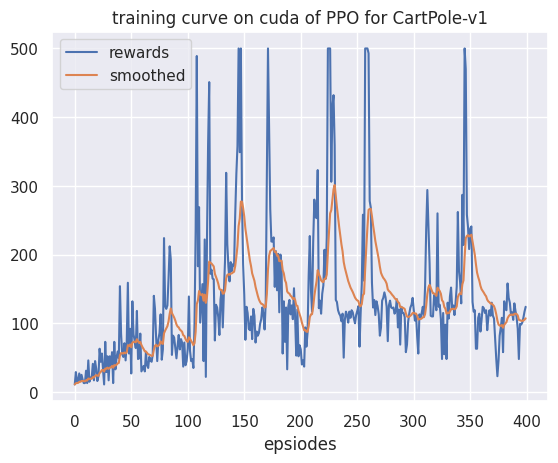

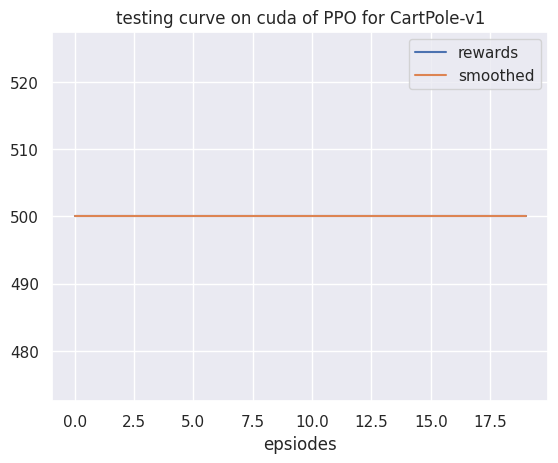

In [13]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
best_agent,res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, best_agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果